### CLS limit calculation

Open the `ROOT` file

In [1]:
TFile* f = TFile::Open("model.root") ;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Retrieve the workspace

In [2]:
RooWorkspace* w = (RooWorkspace*) f->Get("w") ;
w->Print() ;


RooWorkspace(w) w contents

variables
---------
(B,Nobs_CR,Nobs_SR,S,mu,tau)

p.d.f.s
-------
RooProdPdf::model[ model_SR * model_CR ] = 0.00144134
RooPoisson::model_CR[ x=Nobs_CR mean=Nexp_CR ] = 0.0281977
RooPoisson::model_SR[ x=Nobs_SR mean=Nexp_SR ] = 0.0511153

functions
--------
RooFormulaVar::Nexp_CR[ actualVars=(tau,B) formula="tau*B" ] = 200
RooFormulaVar::Nexp_SR[ actualVars=(mu,S,B) formula="mu*S+B" ] = 30

datasets
--------
RooDataSet::observed_data(Nobs_SR,Nobs_CR)

parameter snapshots
-------------------
ModelConfig__snapshot = (mu=1)

named sets
----------
ModelConfig_NuisParams:(B)
ModelConfig_Observables:(Nobs_SR,Nobs_CR)
ModelConfig_POI:(mu)
ModelConfig__snapshot:(mu)
obs:(Nobs_SR,Nobs_CR)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



#### Retrieve the ModelConfig for the S+B hypothesis

Retrieve the ModelConfig and the observed data. Together these uniquely define the statistical problem

In [3]:
RooAbsData* data = w->data("observed_data") ;
RooStats::ModelConfig* sbModel = (RooStats::ModelConfig*) w->obj("ModelConfig") ;  

#### Construct a ModelConfig for the B-only hypothesis

For a CLS-style limit calculation (hypothesis test inversion) we need an explicit specification of the background-only hypothesis == another RooStats::ModelConfig that describe the B-only scenario  

In [4]:
RooStats::ModelConfig* bModel = (RooStats::ModelConfig*) sbModel->Clone("BonlyModel") ;

Here we take a little shortcut from universality by assuming that the POI=0 scenario corresponds to the background-only scenario

Set value POI parameter to zero

In [5]:
RooRealVar* poi = (RooRealVar*) bModel->GetParametersOfInterest()->first();
poi->setVal(0) ;

Configure bModel to encode current poi=0 scenario as its hypothesis 

In [6]:
bModel->SetSnapshot( *poi  );

*NB: To make CLS-style hypothesis calculation macros truly universal workspace files should contain both ModelConfigs upfront*

#### Construct an hypothesis p-value calculator
i.e the calculation of p(sbModel) and p(bModel) for the observed data

Instantiate hypothesis testing calculator assuming asymptotic distributions of the profile likelihood ratio (`PLR`) test statistic. This calculator is fast because it does not need to generate toy data to obtain the distribution of the `PLR` under either hypothesis. It is however only valid at sufficiently high statistics.

In [7]:
RooStats::AsymptoticCalculator  asympCalc(*data, *bModel, *sbModel);

[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize....
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize - Find  best unconditional NLL on observed data
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 B            2.00000e+01  1.00000e+01    0.00000e+00  2.00000e+02
     2 mu           0.00000e+00  5.00000e-01   -1.00000e+00  1.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        1000           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=6.10022 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
              

Configure calculator for a limit (=one-sided interval)

In [8]:
asympCalc.SetOneSided(true); 

#### Construct an hypothesis test inverter

i.e. a tool that can calculate the POI value for which (in this case) CLS==$p(\mathrm{sbModel})/(1-p(\mathrm{Model}))$ takes a certain value. This inversion requires a scan over possible values of $\mu$.

In [9]:
RooStats::HypoTestInverter inverter(asympCalc);

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : ModelConfig
		 using as B (alternate) model  : BonlyModel



Statistical configuration of hypothesis test inverter

In [10]:
inverter.SetConfidenceLevel(0.90);
inverter.UseCLs(true); 

Technical configuration of hypothesis test inverter

In [11]:
inverter.SetVerbose(false);
inverter.SetFixedScan(50,0.0,6.0); // set number of points , xmin and xmax 

Perform calculation of limit

In [12]:
RooStats::HypoTestInverterResult* result =  inverter.GetInterval();

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name ModelConfig__snapshot

[#1] INFO:Eval -- AsymptoticCalculator::GetHypoTest: - perform  an hypothesis test for  POI ( mu ) = 0
[#0] PROGRESS:Eval -- AsymptoticCalculator::GetHypoTest -  Find  best conditional NLL on OBSERVED data set ..... 
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **   13 **SET PRINT           0
 **********
 **********
 **   14 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 B            2.00000e+01  1.41405e+00    0.00000e+00  2.00000e+02
 **********
 **   15 **SET ERR         0.5
 **********
 **********
 **   16 **SET PRINT           0
 **********
 **********
 **   17 **SET STR           1
 **********
 **********
 **   18 **MIGRAD         500           1
 **********
 MIGRAD MI

Print observed limit

In [13]:
cout << 100*inverter.ConfidenceLevel() << "%  upper limit : " << result->UpperLimit() << endl;

90%  upper limit : 1.28592


compute expected limit

In [14]:
std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
std::cout << " expected limit (median) " << result->GetExpectedUpperLimit(0) << std::endl;
std::cout << " expected limit (-1 sig) " << result->GetExpectedUpperLimit(-1) << std::endl;
std::cout << " expected limit (+1 sig) " << result->GetExpectedUpperLimit(1) << std::endl;
std::cout << " expected limit (-2 sig) " << result->GetExpectedUpperLimit(-2) << std::endl;
std::cout << " expected limit (+2 sig) " << result->GetExpectedUpperLimit(2) << std::endl;

Expected upper limits, using the B (alternate) model : 
 expected limit (median) 0.866976
 expected limit (-1 sig) 0.590338
 expected limit (+1 sig) 1.313
 expected limit (-2 sig) 0.429087
 expected limit (+2 sig) 1.92199


Use the visualization tool of the PLC to show how the interval was calculated

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


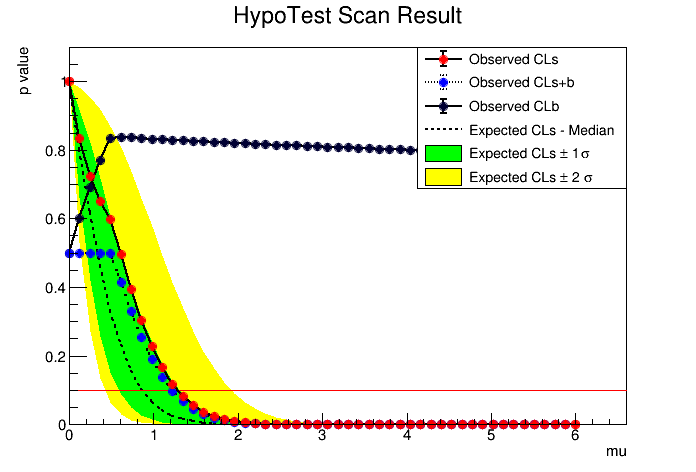

In [15]:
RooStats::HypoTestInverterPlot* plot = new RooStats::HypoTestInverterPlot("HTI_Result_Plot","HypoTest Scan Result",result);
plot->Draw("CLb 2CL");  // plot also CLb and CLs+b 
c1->Draw()